In [1]:
#12/29/20
#runnign synthetic benchmark graphs for synthetic OR datasets generated


In [2]:
#making benchmark images 
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [3]:
#ONLY RUN THIS CELL ONCE 
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [4]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func

#for formulation 2 graphing 
def returnXMeanLogits(e_train):
    #returns x mean logits for displayign the pwm difference for the version 2 networks 
    #Visualize background sequence distribution
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))

    pseudo_count = 1.0

    x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
    x_mean_logits = np.log(x_mean / (1. - x_mean))
    return x_mean_logits, x_mean


In [5]:
#loading testing dataset 

from optimusFunctions import *
import pandas as pd

csv_to_open = "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv"


dataset_name = csv_to_open.replace(".csv", "")
print (dataset_name)
data_df = pd.read_csv("./" + csv_to_open) #open from scores folder 
#loaded test set which is sorted by number of start/stop signals 

seq_e_test = one_hot_encode(data_df, seq_len=50)
benchmarkSet_seqs = seq_e_test
x_test = np.reshape(benchmarkSet_seqs, (benchmarkSet_seqs.shape[0], 1, benchmarkSet_seqs.shape[1], benchmarkSet_seqs.shape[2]))
print (x_test.shape)



optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512
(512, 1, 50, 4)


In [6]:


e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")

print ("training: ", e_train.shape[0], " testing: ", x_test.shape[0])
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_mean_logits, x_mean = returnXMeanLogits(e_train)
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))


training:  15008  testing:  512


In [7]:
#background 

#for formulation 2 graphing 
def returnXMeanLogits(e_train):
    #returns x mean logits for displayign the pwm difference for the version 2 networks 
    #Visualize background sequence distribution
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))

    pseudo_count = 1.0

    x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
    x_mean_logits = np.log(x_mean / (1. - x_mean))
    return x_mean_logits, x_mean

e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
print ("training: ", e_train.shape[0], " testing: ", x_test.shape[0])
#one hot encode with optimus encoders 
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_mean_logits, x_mean = returnXMeanLogits(e_train)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))


training:  15008  testing:  512


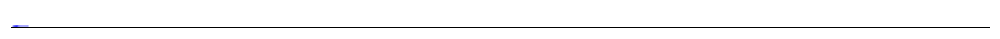

Mean conservation (bits) = 0.032049298346210106
Mean KL Div against background (bits) = 1.9679329305814974


In [8]:
#Define sequence template for optimus

sequence_template = 'N'*50
sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])

#Visualize background sequence distribution

save_figs = True
plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=50)

#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy
x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)
print("Mean conservation (bits) = " + str(x_mean_conservation))

#Calculate mean training set kl-divergence against background
x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)
x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)
print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))



In [9]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 50
n_samples = 128
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)

#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'
predictor = load_model(predictor_path)
predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [10]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 4), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [11]:
#open all score and reshape as needed 

file_names = [
    "l2x_" + dataset_name +  "_importance_scores_test.npy",
    "invase_" + dataset_name +  "_conv_importance_scores_test.npy",
    "l2x_" + dataset_name +  "_full_data_importance_scores_test.npy",
    "invase_" + dataset_name +  "_conv_full_data_importance_scores_test.npy",
]
#deepexplain_optimus_utr_OR_logic_synth_1_start_2_stops_method_integrated_gradients_importance_scores_test.npy

model_names =[
    "l2x",
    "invase",
    "l2x_full_data",
    "invase_full_data",
]

model_importance_scores_test = [np.load("./" + file_name) for file_name in file_names]

for scores in model_importance_scores_test:
    print (scores.shape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)

for scores in model_importance_scores_test:
    print (scores.shape)
    
#reshape for mse script -> if not (3008, 1, 50, 1) make it that shape 
idealShape = model_importance_scores_test[0].shape
print (idealShape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape != idealShape:
        model_importance_scores_test[model_i] = np.expand_dims(model_importance_scores_test[model_i], 1)
        
for scores in model_importance_scores_test:
    print (scores.shape)


(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)


In [12]:

on_state_logit_val = 50.
print (x_test.shape)

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

print (x_test_logits.shape)
print (dummy_test.shape)


x_test_squeezed = np.squeeze(x_test)
y_pred_ref = predictor.predict([x_test_squeezed], batch_size=32, verbose=True)[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)



(512, 1, 50, 4)
(512, 1, 50, 4)
(512, 1)
512/512 [==============================] - 1s 3ms/step


In [13]:
feature_quantiles = [0.76, 0.82, 0.88]

for name in model_names:
    for quantile in feature_quantiles:
        totalName = name + "_" + str(quantile).replace(".","_") + "_quantile_MSE"
        data_df[totalName] = None
    
print (data_df.columns)

Index(['Unnamed: 0', 'utr', 'gt', 'orig', 'l2x_0_76_quantile_MSE',
       'l2x_0_82_quantile_MSE', 'l2x_0_88_quantile_MSE',
       'invase_0_76_quantile_MSE', 'invase_0_82_quantile_MSE',
       'invase_0_88_quantile_MSE', 'l2x_full_data_0_76_quantile_MSE',
       'l2x_full_data_0_82_quantile_MSE', 'l2x_full_data_0_88_quantile_MSE',
       'invase_full_data_0_76_quantile_MSE',
       'invase_full_data_0_82_quantile_MSE',
       'invase_full_data_0_88_quantile_MSE'],
      dtype='object')


In [14]:

feature_quantiles = [0.76, 0.82, 0.88]

#batch_size = 128 
from sklearn import metrics
model_mses = []
for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_mses = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][feature_quantile_i, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        n_to_test = importance_scores_test.shape[0] // batch_size * batch_size
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)
        print (samples_test.shape)
        msesPerPoint = []
        for data_ix in range(samples_test.shape[0]) :
            #for each sample, look at kl divergence for the 128 size batch generated 
            #for MSE, just track the pred vs original pred 
            if data_ix % 1000 == 0 :
                print("Processing example " + str(data_ix) + "...")
            
            #from optimus R^2, MSE, Pearson R script 
            justPred = np.expand_dims(np.expand_dims(x_test[data_ix, 0, :, :], axis=0), axis=-1)
            justPredReshape = np.reshape(justPred, (1,50,4))
            
            expanded = np.expand_dims(samples_test[data_ix, :, 0, :, :], axis=-1) #batch size is 128 
            expandedReshape = np.reshape(expanded, (n_samples, 50,4))
            
            y_test_hat_ref = predictor.predict(x=justPredReshape, batch_size=1)[0][0]
            
            y_test_hat = predictor.predict(x=[expandedReshape], batch_size=32)
            
            pwmGenerated = y_test_hat.tolist()
            tempOriginals = [y_test_hat_ref]*y_test_hat.shape[0]
            
            asArrayOrig = np.array(tempOriginals)
            asArrayGen = np.array(pwmGenerated)
            squeezed = np.squeeze(asArrayGen)
            mse = metrics.mean_squared_error(asArrayOrig, squeezed)
            #msesPerPoint.append(mse)
            totalName = model_names[model_i] + "_" + str(feature_quantile).replace(".","_") + "_quantile_MSE"
            data_df.at[data_ix, totalName] = mse
            msesPerPoint.append(mse)
        msesPerPoint = np.array(msesPerPoint)
        feature_quantile_mses.append(msesPerPoint)
    model_mses.append(feature_quantile_mses)

Benchmarking model 'l2x'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'invase'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'l2x_full_data'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...
Benchmarking model 'invase_full_data'...
Feature quantile = 0.76
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.82
(512, 128, 1, 50, 4)
Processing example 0...
Feature quantile = 0.88
(512, 128, 1, 50, 4)
Processing example 0...


--- MSEs ---
----------------   0.76   0.82   0.88
L2X                2.49   2.51   2.61
INVASE             2.08   2.24   2.47
L2X_FULL_DATA      2.28   2.40   2.56
INVASE_FULL_DATA   2.77   2.80   2.85



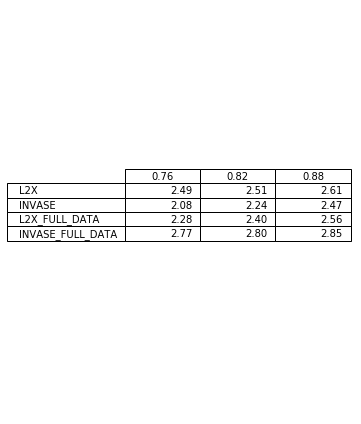

In [15]:
#Store benchmark results as tables

save_figs = False

mse_table = np.zeros((len(model_mses), len(model_mses[0])))

for i, model_name in enumerate(model_names) :
    
    for j, feature_quantile in enumerate(feature_quantiles) :
        
        mse_table[i, j] = np.mean(model_mses[i][j])

#Plot and store mse table
f = plt.figure(figsize = (4, 6))

cells = np.round(mse_table, 3).tolist()

print("--- MSEs ---")
max_len = np.max([len(model_name.upper().replace("\n", " ")) for model_name in model_names])
print(("-" * max_len) + "   " + "   ".join([(str(feature_quantile) + "0")[:4] for feature_quantile in feature_quantiles]))
for i in range(len(cells)) :
    
    curr_len = len([model_name.upper().replace("\n", " ") for model_name in model_names][i])
    row_str = [model_name.upper().replace("\n", " ") for model_name in model_names][i] + (" " * (max_len - curr_len))
    
    for j in range(len(cells[i])) :
        cells[i][j] = (str(cells[i][j]) + "00000")[:4]
        
        row_str += "   " + cells[i][j]
    
    print(row_str)

print("")

table = plt.table(cellText=cells, rowLabels=[model_name.upper().replace("\n", " ") for model_name in model_names], colLabels=feature_quantiles, loc='center')

ax = plt.gca()
#f.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

plt.tight_layout()

if save_figs :
    plt.savefig(dataset_name + "_l2x_and_invase_full_data" + "_mse_table.png", dpi=300, transparent=True)
    plt.savefig(dataset_name + "_l2x_and_invase_full_data" + "_mse_table.eps")

plt.show()
